# Generative Adversarial Neural Network for the MNIST Dataset

See the original GAN [paper](https://arxiv.org/pdf/1406.2661.pdf) and this Open AI [blog post](https://openai.com/blog/generative-models/) related to this [article](https://arxiv.org/abs/1606.03498).

In implementing this, I have used some of the recommendations given in the [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf).

Finally, TensorFlow has recently added a [blog post](https://www.tensorflow.org/tutorials/generative/dcgan) on a simple DCGAN for the MNIST dataset. While that tutorial is quite concise, there are some aspects that presumably require further clarification. I have deliberately set the size of hidden representation to a small number (~32). The main reason for this is that the MNIST data already is fairly restricted and the dataset has a much smaller information content than, say, CIFAR-10.  

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from tqdm import tqdm

import utilities as utils
import models 

<br><br><br>

# Training Parameters 

In [2]:
batch_size = 256
num_epochs = 100
generator_input_size = 32

<br><br><br>

# Input Data Pipeline

## Load MNIST Dataset

In [3]:
train_set, test_set = tf.keras.datasets.mnist.load_data()
print(f"\tTrain set: {train_set[0].shape}, {train_set[1].shape}")
print(f"\tTest set:  {test_set[0].shape}, {test_set[1].shape}")

	Train set: (60000, 28, 28), (60000,)
	Test set:  (10000, 28, 28), (10000,)


## Setup Data Pipeline:

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(train_set[0])
dataset = dataset.batch(batch_size, drop_remainder=True)

def include_gen_model_input(
    x, batch_size=batch_size, generator_input_size=generator_input_size):
    x_gen = tf.random.normal(
        shape=(batch_size, generator_input_size), 
        mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
    return (x, x_gen)
dataset = dataset.map(include_gen_model_input)

# # Draw samples from the data pipeline
# for element in dataset.take(3):
#     print("\t", element[0].shape, "\t", element[1].shape)

<br><br><br>

# Train the Generator Model in an Adversarial Setting

## Instantiate Discriminator and Generator Models

In [5]:
# Instantiate
discriminator_model = models.construct_discriminator_model()
generator_model = models.construct_generator_model(
        input_size=generator_input_size, 
        output_activation="linear",
        with_batchnorm=True)

# Print Summaries
discriminator_model.summary(print_fn=(lambda *args: print("\t", *args)))
print("\n\n")
generator_model.summary(print_fn=(lambda *args: print("\t", *args)))

	 Model: "discriminator"
	 _________________________________________________________________
	 Layer (type)                 Output Shape              Param #   
	 input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
	 _________________________________________________________________
	 conv_1 (Conv2D)              (None, 28, 28, 8)         208       
	 _________________________________________________________________
	 conv_2 (Conv2D)              (None, 28, 28, 32)        6432      
	 _________________________________________________________________
	 flatten (Flatten)            (None, 25088)             0         
	 _________________________________________________________________
	 output (Dense)               (None, 2)                 50178     
	 Total params: 56,818
	 Trainable params: 56,818
	 Non-trainable params: 0
	 _________________________________________________________________



	 Model: "generator"
	 _________________________________________________________

## Create and Initialize the Custom GAN Training Class

In [6]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.1, 
    momentum=0.0, nesterov=False, name="SGD")

train_gan = models.Train_GAN_Modules(
    discriminator_model=discriminator_model,
    generator_model=generator_model,
    batch_size=batch_size,
    optimizer=optimizer)

## Sample of Generated Images before Training:

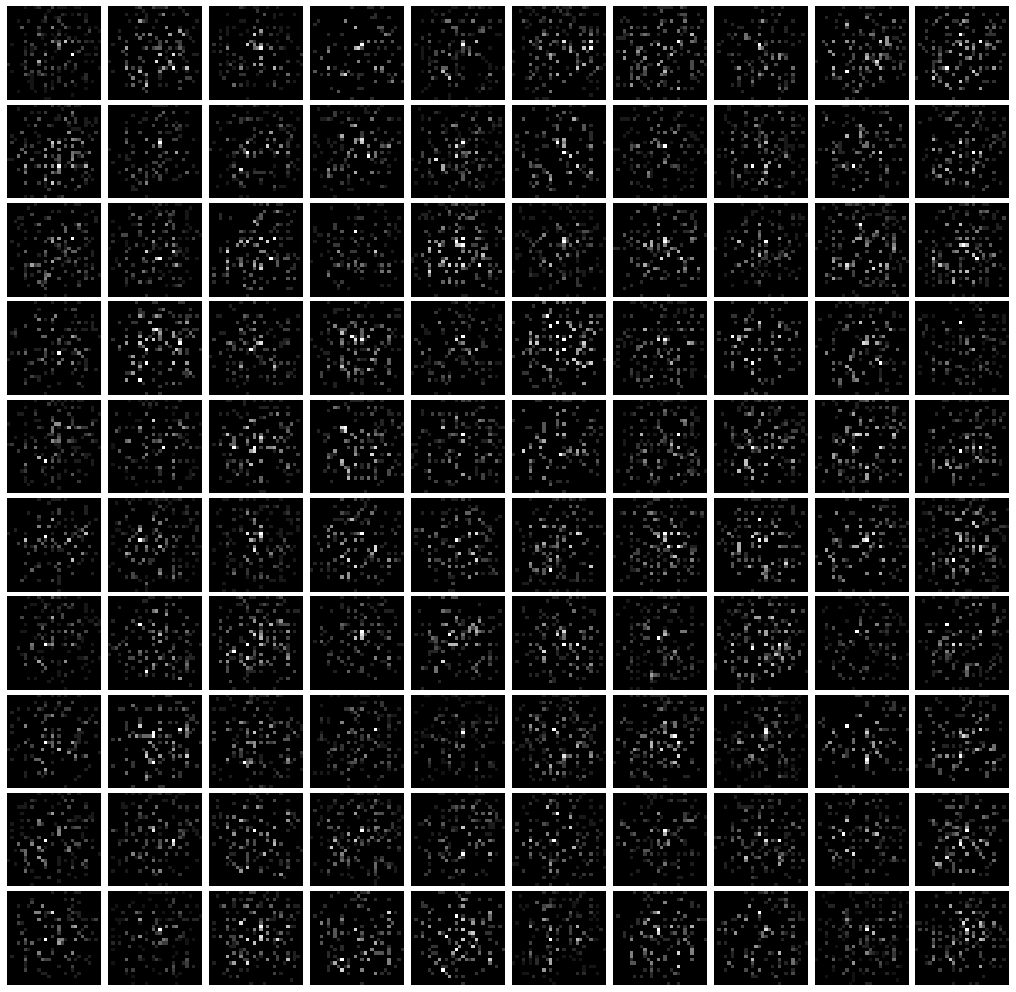

In [7]:
num_rows = 10
num_cols = 10

# Generate some images:
x = tf.random.normal(
    shape=(num_rows * num_cols, generator_input_size), 
    mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
images = train_gan.generator_model(x).numpy()

fig = plt.figure(figsize=(18., 18.))
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.05, hspace=0.05)
for row in range(num_rows):
    for col in range(num_cols):
        idx = row * num_cols + col
        ax = plt.subplot(gs[idx])
        image = images[idx]
        image = np.clip(image, 0.0, 255.0).astype(np.uint8)
        #
        ax.imshow(image, cmap="gray")
        ax.axis("off")
plt.show()

## Train the GAN Model

In [ ]:
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}", flush=True)
    train_gan.reset_accumulated_losses()
    pbar = tqdm(dataset.take(-1).enumerate(start=1))
    for idx, element in pbar: 
        image_batch, generator_input_batch = element
        losses = train_gan.train_step(
            image_batch, generator_input_batch)
        pbar.set_description("\t[{}] {}, {}, {}".format(
            idx.numpy(), round(losses[0], 5), round(losses[1], 5), round(losses[2], 5)))
    accumulated_losses = train_gan.get_accumulated_losses()
    for loss_name, loss_val in accumulated_losses.items():
        print(f"\t{loss_name:48} {round(loss_val, 5)}", flush=True)
    print("", flush=True)


Epoch 1/100


	[11] 0.0, 16.1181, 0.0:   5%|▍         | 11/234 [00:17<05:52,  1.58s/it]      

<br><br><br>

# Generate Images

In [ ]:
num_rows = 10
num_cols = 10

# Generate some images:
x = tf.random.normal(
    shape=(num_rows * num_cols, generator_input_size), 
    mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
images = train_gan.generator_model(x).numpy()

fig = plt.figure(figsize=(18., 18.))
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.05, hspace=0.05)
for row in range(num_rows):
    for col in range(num_cols):
        idx = row * num_cols + col
        ax = plt.subplot(gs[idx])
        image = images[idx]
        image = np.clip(image, 0.0, 255.0).astype(np.uint8)
        #
        ax.imshow(image, cmap="gray")
        ax.axis("off")
plt.show()